# Machine Learning & Parallelization

Algorithms can generally be placed into one of three categories:

##### Supervised learning 
    - f(X) = Y
    - i.e. regression, classification
    - Decision trees, Support Vector Machines, Neural Networks, ...
    
    
##### Unsupervised learning 
    - f(X) = X'
    - i.e. clustering, dimensionality reduction
    - K-Means, Expectation Maximization, Principal component analysis, ...
    
##### Reinforcement learning: 
    - f(S, A, T, R) = π
    - i.e. optimal policy for markov decision processes 
    - Q-Learning, SARSA, Temporal Differencing, ...

Also some which might fit in multiple e.g. Semi-supervised learning algorithms

### Supervised Learning

First step is getting the data. 

*Open University Learning Analytics Data (OULAD):* https://archive.ics.uci.edu/ml/datasets/Open+University+Learning+Analytics+dataset

**Objective:** predict a student's final result (distinction, fail, pass, withdraw)

Assume we downloaded and unzipped in ./Data folder...

In [1]:
from glob import glob
import csv 

for filename in glob('Data/*.csv'):
    reader = csv.reader( open(filename) )
    header = next(reader)
    #length = len(list(reader)) # don't do this with large files - reads all into memory
    length = sum(1 for line in reader)
    
    print('%s: %i samples, %i features' % (filename, length, len(header)))
    print('\t','\n\t'.join(header),'\n')
        

Data\assessments.csv: 206 samples, 6 features
	 code_module
	code_presentation
	id_assessment
	assessment_type
	date
	weight 

Data\courses.csv: 22 samples, 3 features
	 code_module
	code_presentation
	module_presentation_length 

Data\studentAssessment.csv: 173912 samples, 5 features
	 id_assessment
	id_student
	date_submitted
	is_banked
	score 

Data\studentInfo.csv: 32593 samples, 12 features
	 code_module
	code_presentation
	id_student
	gender
	region
	highest_education
	imd_band
	age_band
	num_of_prev_attempts
	studied_credits
	disability
	final_result 

Data\studentRegistration.csv: 32593 samples, 5 features
	 code_module
	code_presentation
	id_student
	date_registration
	date_unregistration 

Data\studentVle.csv: 10655280 samples, 6 features
	 code_module
	code_presentation
	id_student
	id_site
	date
	sum_click 

Data\vle.csv: 6364 samples, 6 features
	 id_site
	code_module
	code_presentation
	activity_type
	week_from
	week_to 



We see that there are:
- 32,953 student records (potentially with duplicate students)
- 22 courses
- 6364 VLEs ("virtual learning environment" - web page, essentially)
- 10,655,280 VLE student interactions 
- 206 assessments 
- 173,912 assessment results from students

Objective: StudentInfo final_result

This means there are 32,953 samples we can learn from - one per student. So we have 11 (no id_student) features from studentInfo, and 1 (date_registration) from studentRegistration...what about others? Unclear exactly how we might represent the remaining data to an algorithm.

There are also some fields that would be "cheating" to know a priori:
    - date_unregistration: only filled for students who have withdrawn
    - assessment scores: having all of these with the weights gives the final result itself
    - clicks on a VLE? Depends on when in the process you want to create a classifier for
    
In practice, the fields you can use are determined by what the algorithm has available at test time. If you want to predict student grades based on their information at registration, only the 12 previously mentioned fields can be used.

Intuitively, it should be very difficult to predict a student's final result based solely on that information...but let's give it a shot.

In [2]:
from IPython.display import display
import pandas as pd 
import numpy as np
pd.set_option('display.max_rows', 7)

info = pd.read_csv('Data/studentInfo.csv')
regr = pd.read_csv('Data/studentRegistration.csv')

display(info)
display(regr)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
...,...,...,...,...,...,...,...,...,...,...,...,...
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn
32592,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction


,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159,?
1,AAA,2013J,28400,-53,?
2,AAA,2013J,30268,-92,12
...,...,...,...,...,...
32590,GGG,2014J,2648187,-129,?
32591,GGG,2014J,2679821,-49,101
32592,GGG,2014J,2684003,-28,?


According to the dataset's information, date_registration is the number of days relative to the start of the actual course - meaning it's already preprocessed for us!

Now that we have the data, we need to combine it into one set. Also important to note that the id_student fields are in the same order. Otherwise, we would need to go row by row to combine them.

In [3]:
assert(info['id_student'].equals(regr['id_student']))
data = info.join(regr['date_registration'])
display(data)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49
32592,GGG,2014J,2684003,F,Yorkshire Region,HE Qualification,50-60%,35-55,0,30,N,Distinction,-28


One last step before we're ready for the algorithm. Notice the data above uses text data for the majority of features. For any algorithm to work, we need to convert these into numerical representations. 

So, best way to do that? Simplest way is to just assign a number to each unique value in a feature. However, that implies an ordering on the feature. For some, e.g. age_band, that may make sense; but what would it mean to say Scotland > North Western Region? Yorkshire Region comes before the South Region? Nominal vs. Ordinal features.

For these types of features - those without a natural ordering - we use a one-hot encoding vector. For example, a feature set <br>
[Red, Green, Red, Blue]<br> 
might be changed to <br>
[[1 0 0]<br>
 [0 1 0]<br>
 [1 0 0]<br>
 [0 0 1]]<br>

Each column therefore represents the presence or lack of a certain attribute.

In [4]:
code_module = pd.get_dummies(data['code_module'])
display(code_module)
print('\n'+'\n'.join(['%s: %i' % (col, data[col].nunique()) for col in data]))

,AAA,BBB,CCC,DDD,EEE,FFF,GGG
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
32590,0,0,0,0,0,0,1
32591,0,0,0,0,0,0,1
32592,0,0,0,0,0,0,1



code_module: 7
code_presentation: 4
id_student: 28785
gender: 2
region: 13
highest_education: 5
imd_band: 11
age_band: 3
num_of_prev_attempts: 7
studied_credits: 61
disability: 2
final_result: 4
date_registration: 333


While potentially subjective, we'll label code_module, code_presentation, gender, region, and disability as nominal values. This gives us (7 + 4 + 2 + 13 + 1 + 1 + 1 + 1 + 1 + 2 + 1 + 1) = 35 features. We then also need to relabel the ordinal values with a logical ordering.

In [5]:
ordinal = ['highest_education', 'imd_band', 'age_band', 'final_result']
print('\n'.join(['%s: %s' % (col, data[col].unique()) for col in ordinal]) + '\n')

# '?' doesn't have an ordering against the others. One way to take care of it (other than 
# classifying as nominal) is to drop those 1,111 samples. Another option is to label as NaN
# if the chosen ML algorithm can handle these values
for col in data.columns:
    if '?' in set(data[col]):
        print('Column %s has %s unknown values' % (col, data[col].value_counts()['?']))
        

highest_education: ['HE Qualification' 'A Level or Equivalent' 'Lower Than A Level'
 'Post Graduate Qualification' 'No Formal quals']
imd_band: ['90-100%' '20-30%' '30-40%' '50-60%' '80-90%' '70-80%' '?' '60-70%'
 '40-50%' '10-20' '0-10%']
age_band: ['55<=' '35-55' '0-35']
final_result: ['Pass' 'Withdrawn' 'Fail' 'Distinction']

Column imd_band has 1111 unknown values
Column date_registration has 45 unknown values


In [6]:
def clean_data(data):
    numeric_keys = ['num_of_prev_attempts', 'studied_credits', 'date_registration']
    nominal_keys = ['code_module', 'code_presentation', 'region', 'disability', 'gender']
    ordinal_keys = {'highest_education': ['No Formal quals', 'Lower Than A Level', 'A Level or Equivalent', 
                                          'HE Qualification', 'Post Graduate Qualification'],
                   'imd_band': ['0-10%', '10-20', '20-30%', '30-40%', '40-50%', '50-60%',
                                '60-70%', '70-80%', '80-90%', '90-100%'],
                   'age_band': ['0-35', '35-55', '55<='],
    #                 'gender':['M', 'F'],
                   'final_result': ['Fail', 'Withdrawn', 'Pass', 'Distinction']}
    
    # Get rid of unknown values
    data = data.drop('id_student', axis=1).replace({'?':np.nan})

    all_keys = numeric_keys + nominal_keys + list(ordinal_keys.keys()) 
    remaining_keys = set(data.columns) - set(all_keys)
    numeric_keys += list(remaining_keys)
    
    def to_ord(x, order):
        y = x.astype('category', categories=order)
        return y.cat.codes

    # Numeric columns
    numeric = data[numeric_keys]

    # One-hot encoded nominal columns
    nominal = pd.get_dummies(data[nominal_keys])

    # Set the ordinal columns as a 'category' type and retrieve the resulting conversion
    # Can only do this with series, so have to perform column-by-column and then reform into a dataframe
    ordinal = np.array([to_ord(data[o], ordinal_keys[o]) for o in sorted(ordinal_keys)])
    ordinal = pd.DataFrame(ordinal.T, columns=sorted(ordinal_keys))

    # Join the dataframes together, drop nan values, convert to integers, and reset the index back to default
    final_data = numeric.join(nominal).join(ordinal).dropna().astype(np.int32).reset_index(drop=True)
    return final_data

final_data = clean_data(data)
display(final_data)

,num_of_prev_attempts,studied_credits,date_registration,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,...,region_West Midlands Region,region_Yorkshire Region,disability_N,disability_Y,gender_F,gender_M,age_band,final_result,highest_education,imd_band
0,0,240,-159,1,0,0,0,0,0,0,...,0,0,1,0,0,1,2,2,3,9
1,0,60,-53,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,2,3,2
2,0,60,-92,1,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32545,0,30,-129,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,2,2,2
32546,0,30,-49,0,0,0,0,0,0,1,...,0,0,1,0,1,0,1,1,1,9
32547,0,30,-28,0,0,0,0,0,0,1,...,0,1,1,0,1,0,1,3,3,5


### Choosing an algorithm

*Algorithm choice without background knowledge is arbitrary.*

"No Free Lunch" theorem:<br>
    - "We have dubbed the associated results NFL theorems because they demonstrate that if an algorithm performs well on a certain class of problems then it necessarily pays for that with degraded performance on the set of all remaining problems." - Wolpert & Macready (1997)
    
Luckily, there is always background knowledge. We can *assume* a great deal even without knowing this data set:
- samples that have similar features are usually going to be similarly classified
- there will likely be outliers in the data
- there is going to be little or no noise in our current feature set
- there is not any timeseries component or ordering in time to these features
- many other assumptions we make by the sheer fact of having this dataset. 

These remove choices like reinforcement learning algorithms, NLP algorithms, forecasting algorithms, etc. 

There is also the background knowledge of what you would like to receive from the algorithm: 
- interpretable model?
- feature importances?
- exact boundary conditions?
- exact function approximation?
- speed?

All of these contribute to the choice of algorithm. Here, we'll use decision trees - they essentially provide four of the five above conditions, and are fairly powerful for such a simple model.

### (binary) Decision Trees

Quick summary:
- Tree is built by selecting a feature to 'split' on at each node; all samples with the feature value go to one branch, and all other samples go to the other
- Few different splitting metrics, but Gini and Information Gain are the most common. General idea is to determine which feature choice gives the greatest separation between target classes
- Adaptable to continuous data as well as regression settings

Simple decision tree for passenger survival on the Titanic (credit wikipedia):
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png"/>

In [7]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

def split_data(X, Y, pct=0.2):
    ''' Divide data into training / validation set '''
    X = X.as_matrix()
    samples = X.shape[0]
    n_train = int(samples * pct) 
    indices = np.arange(samples)
    np.random.shuffle(indices)

    # Training set
    Xt = X[indices[:n_train]]
    Yt = Y[indices[:n_train]]

    # Validation set
    Xv = X[indices[n_train:]]
    Yv = Y[indices[n_train:]]
    return (Xt, Yt), (Xv, Yv)


def fit_data(X, Y, kwargs={}, Model=DecisionTreeClassifier):
    '''
    Fit model and test performance on a validation set
    
    kwargs:
     - max_depth
     - max_leaf_nodes
     - min_impurity_split
     - min_samples_split
     - min_samples_leaf
     - criterion
     - class_weight
    '''
    training, (Xv, Yv) = split_data(X, Y)

    model = Model(**kwargs).fit(*training)
    Y_hat = model.predict(Xv)

    print('Accuracy:', accuracy_score(Yv, Y_hat))
    print('F1:', f1_score(Yv, Y_hat, average='weighted'))
    print('Confusion Matrix:\n', confusion_matrix(Yv, Y_hat))
    return model

In [8]:
Y = final_data['final_result']
X = final_data.drop('final_result', axis=1)

fit_data(X, Y)

Accuracy: 0.344406467222
F1: 0.344536562152
Confusion Matrix:
 [[1451 1674 2078  449]
 [1665 3063 2715  633]
 [2098 2693 4089 1002]
 [ 452  625  987  365]]


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Not so great. So, what do we do now?

A few options:
 - Change the objective
 - Improve model
 - Improve data


In [9]:
Y = final_data['final_result'].replace({1:0, 2:1, 3:1}) # Fail, Withdraw, Pass, Distinction -> Incomplete, Complete
X = final_data.drop('final_result', axis=1)

fit_data(X, Y)

Accuracy: 0.549560274972
F1: 0.549636735097
Confusion Matrix:
 [[7800 5909]
 [5820 6510]]


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Improvement, but still not much better than a coin flip. How about improving the model?

In [10]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer
from time import time

# Create a timing decorator 
def timer(f):
    def wrapper(*args, **kwargs):
        start  = time()
        result = f(*args, **kwargs)
        print('Execution time: %.2f seconds' % (time() - start))
        return result
    return wrapper


# Split data using sklearn
Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.2)

@timer
def run_search_dt(n_jobs=1):
    search = GridSearchCV(estimator = DecisionTreeClassifier(),
                          param_grid= {'max_depth'      : np.arange(2, 11),
                                       'max_leaf_nodes' : np.linspace(8, 100, 10, dtype=np.int32),
                                       'criterion'      : ['gini', 'entropy'],
                                       'class_weight'   : ['balanced', None]},
                          scoring = make_scorer(f1_score),
                          n_jobs  = n_jobs,
                          cv      = 3) # 3 fold cross validation
    search.fit(Xt, Yt)
    display(pd.DataFrame(search.cv_results_))
    print('Best score: %.3f' % search.best_score_)
    return search.best_params_
    
    
params = run_search_dt()
print(params)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_class_weight,param_criterion,param_max_depth,param_max_leaf_nodes,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.027512,0.005207,0.551970,0.552908,balanced,gini,2,8,"{'criterion': 'gini', 'class_weight': 'balance...",280,0.525991,0.534120,0.598609,0.597353,0.531313,0.527251,0.005206,0.007364,0.033049,0.031552
1,0.041100,0.001730,0.551970,0.552908,balanced,gini,2,18,"{'criterion': 'gini', 'class_weight': 'balance...",280,0.525991,0.534120,0.598609,0.597353,0.531313,0.527251,0.002624,0.001268,0.033049,0.031552
2,0.035354,0.003008,0.551970,0.552908,balanced,gini,2,28,"{'criterion': 'gini', 'class_weight': 'balance...",280,0.525991,0.534120,0.598609,0.597353,0.531313,0.527251,0.000230,0.000009,0.033049,0.031552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,0.059203,0.003180,0.579471,0.600455,None,entropy,10,79,"{'criterion': 'entropy', 'class_weight': None,...",239,0.580054,0.612514,0.580621,0.599291,0.577739,0.589562,0.001327,0.000228,0.001247,0.009406
358,0.060869,0.003176,0.577777,0.597397,None,entropy,10,89,"{'criterion': 'entropy', 'class_weight': None,...",244,0.585075,0.614682,0.580685,0.599751,0.567571,0.577757,0.000474,0.000231,0.007436,0.015166
359,0.060377,0.003168,0.578798,0.601337,None,entropy,10,100,"{'criterion': 'entropy', 'class_weight': None,...",242,0.583283,0.614305,0.584970,0.609933,0.568140,0.579773,0.000471,0.000236,0.007567,0.015352


Best score: 0.612
Execution time: 61.31 seconds
{'criterion': 'gini', 'class_weight': 'balanced', 'max_leaf_nodes': 18, 'max_depth': 5}


In [11]:
params = run_search_dt(4)
fit_data(X, Y, params)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_class_weight,param_criterion,param_max_depth,param_max_leaf_nodes,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.038130,0.002335,0.551970,0.552908,balanced,gini,2,8,"{'criterion': 'gini', 'class_weight': 'balance...",280,0.525991,0.534120,0.598609,0.597353,0.531313,0.527251,0.000434,0.001651,0.033049,0.031552
1,0.044694,0.004503,0.551970,0.552908,balanced,gini,2,18,"{'criterion': 'gini', 'class_weight': 'balance...",280,0.525991,0.534120,0.598609,0.597353,0.531313,0.527251,0.005208,0.000708,0.033049,0.031552
2,0.041695,0.003837,0.551970,0.552908,balanced,gini,2,28,"{'criterion': 'gini', 'class_weight': 'balance...",280,0.525991,0.534120,0.598609,0.597353,0.531313,0.527251,0.000236,0.000237,0.033049,0.031552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,0.087895,0.003836,0.579471,0.600455,None,entropy,10,79,"{'criterion': 'entropy', 'class_weight': None,...",239,0.580054,0.612514,0.580621,0.599291,0.577739,0.589562,0.003067,0.000236,0.001247,0.009406
358,0.084392,0.003837,0.577777,0.597397,None,entropy,10,89,"{'criterion': 'entropy', 'class_weight': None,...",244,0.585075,0.614682,0.580685,0.599751,0.567571,0.577757,0.008572,0.000236,0.007436,0.015166
359,0.068219,0.003336,0.578773,0.601337,None,entropy,10,100,"{'criterion': 'entropy', 'class_weight': None,...",242,0.583283,0.614305,0.584970,0.609933,0.568066,0.579773,0.004586,0.000236,0.007602,0.015352


Best score: 0.612
Execution time: 24.75 seconds
Accuracy: 0.596605092361
F1: 0.596680566707
Confusion Matrix:
 [[7818 5880]
 [4624 7717]]


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=18, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Ensembles

Ensemble learning is the idea that we can potentially combine multiple models into one bigger model, which on average outputs better estimates than any of its constituents. 

Number of different approaches:
 - Bayesian methods
 - Stacking
 - Bagging
 - Boosting
 - ...
 
Longer training times, but typically ensembles using even extremely simple models (e.g. single split decision tree "stumps") can outperform more specialized models. 


### Boosting

Given a weak learner i.e. performing consistently better than random, are we able to make it a strong learner?

Yes: 

#### AdaBoost

Assume you've trained the weak learner and have its outputs on the training set. These outputs match well with some examples, and poorly with others. The poor output samples can be reweighted to have a higher importance in the training set, and then another training round for a weak learner is performed. 

Each weak learner has an associated weight based on its overall sample-weighted performance. These are used after all boosting rounds are completed to combined the weak learners into a single ensemble model. 


#### Gradient Boosting

Continuing with that idea: rather than reweight the samples and refit them at each iteration, we can instead fit the residual at each step - the negative gradient of the squared error:

$F_{t+1}(x) = \dfrac{\delta L(y, F_t(x))}{\delta F_t(x)} = y - F_t(x)$

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn  import XGBClassifier

timed_test = timer(fit_data)

for M in [AdaBoostClassifier, XGBClassifier]:
    print(M.__name__)
    timed_test(X, Y, Model=M)
    print()
    


c:\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


AdaBoostClassifier
Accuracy: 0.621222013134
F1: 0.620006658467
Confusion Matrix:
 [[9235 4461]
 [5402 6941]]
Execution time: 0.42 seconds

XGBClassifier
Accuracy: 0.621644456392
F1: 0.621351569756
Confusion Matrix:
 [[8988 4780]
 [5072 7199]]
Execution time: 0.30 seconds



## Feature Importance

One benefit to using tree-based methods is that they are white-boxes: their models are easily explainable. This leads to easy calculation of things like feature importance and decision paths.  

In [13]:
model = fit_data(X, Y, Model=XGBClassifier)
importance = sorted(list(zip(X.columns, model.feature_importances_)), key=lambda k:k[1], reverse=True)
print('Top three features:')
display(importance[:3])

Accuracy: 0.623987096279
F1: 0.621077814743
Confusion Matrix:
 [[9645 4045]
 [5746 6603]]
Top three features:


[('date_registration', 0.2228739),
 ('studied_credits', 0.12463343),
 ('imd_band', 0.11583578)]

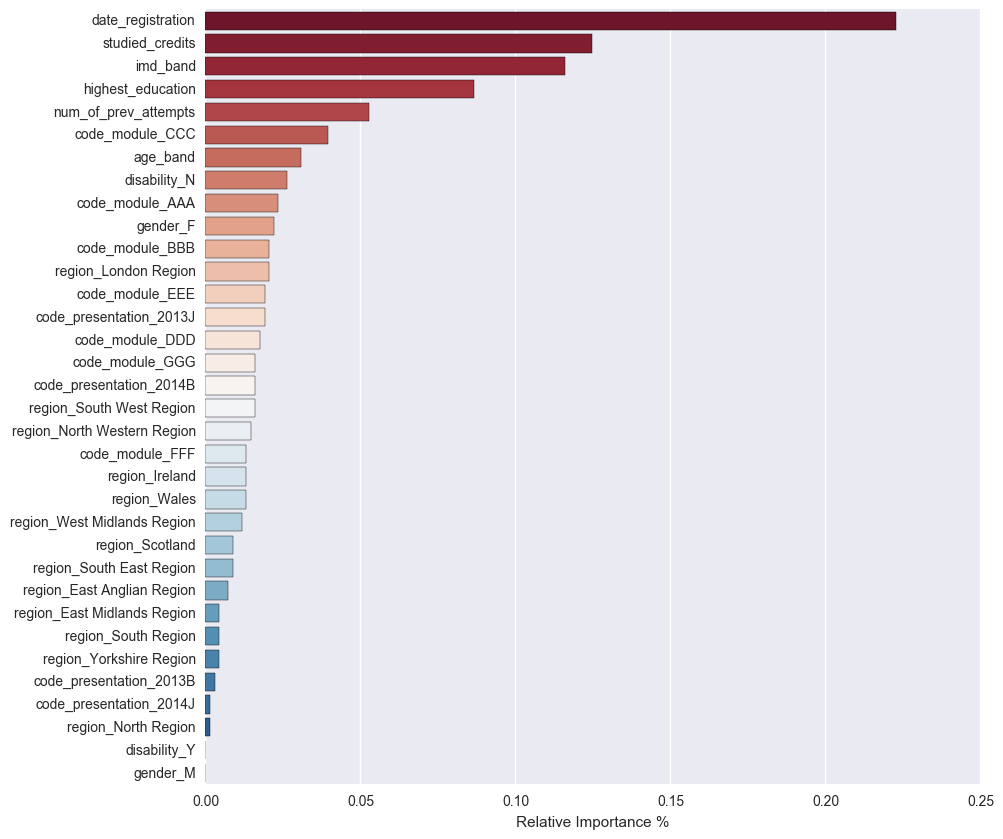

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

imp = np.array(importance)
imp = pd.DataFrame(imp[:,1], index=imp[:,0]).T

plt.figure(figsize=(10,10))
sns.barplot(data=imp, orient='h', palette='RdBu').set_xlabel('Relative Importance %')

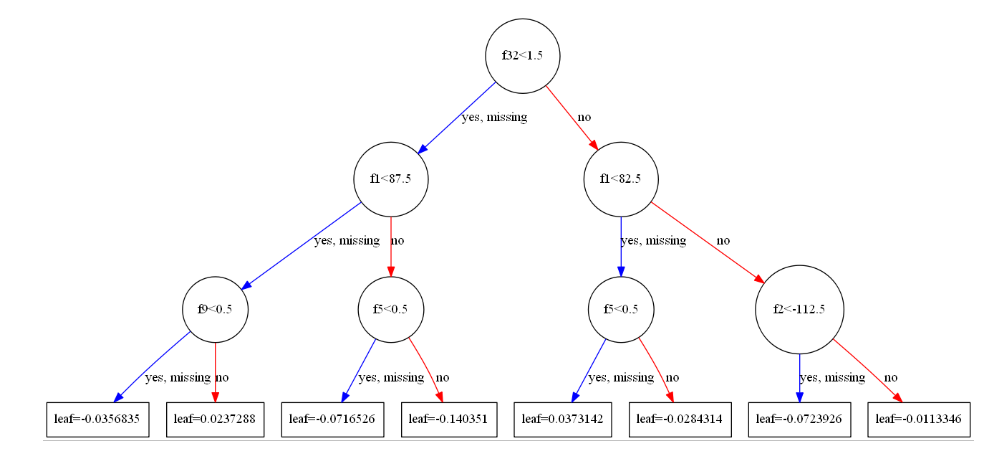

In [15]:
from xgboost.plotting import plot_tree
plt.figure(figsize=(12,12))
plot_tree(model, ax=plt.gca())

# Learning Curves

Another thing we can look at is the learning curves, to judge a few different things. 

1. Determine if more data would improve the results
2. Check if our model is overfitting
3. Bias / variance examination


#### Bias-variance tradeoff 

Generally speaking:
 - Bias: error on the data; high bias = underfitting
 - Variance: sensitivity to small differences between samples; high variance = overfitting
 
Supervised learning models always have an inherent bias-variance tradeoff in their construction. Usually this is tweakable via the hyperparameters of the model, such as with the maximum depth of a decision tree.  

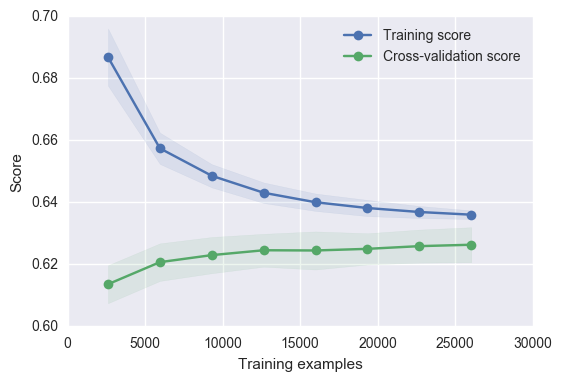

In [16]:
from sklearn.model_selection import learning_curve, ShuffleSplit

def plot_learning_curve(X, Y, Model=XGBClassifier):
    cv = ShuffleSplit(n_splits=30, test_size=0.2)
    train_sizes = np.linspace(0.1,1,8)
    train_sizes, train_scores, test_scores = learning_curve(Model(), X, Y, cv=cv, train_sizes=train_sizes, n_jobs=4)
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    test_mean  = np.mean(test_scores, axis=1)
    test_std   = np.std(test_scores, axis=1)

    c1 = plt.plot(train_sizes, train_mean, 'o-', label="Training score")[0].get_color()
    c2 = plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score")[0].get_color()

    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color=c1)
    plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.1, color=c2)

    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
plot_learning_curve(X, Y)


Other than that, feature engineering would be the next step:
 - group of students in the same code module?
 - student in multiple code modules?
 - student performance in prior modules?
 - etc. 
 
Let's take a look at the data again however - maybe changing our objective to a point-in-time estimate will get better results.

In [17]:
vle = pd.read_csv('Data/studentVle.csv')
display(vle)

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
...,...,...,...,...,...,...
10655277,GGG,2014J,654064,896943,269,3
10655278,GGG,2014J,654064,896939,269,1
10655279,GGG,2014J,654064,896939,269,1


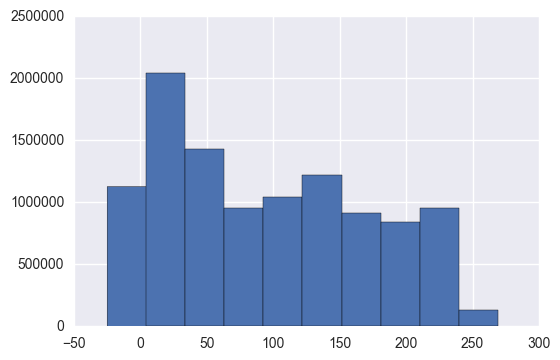

In [18]:
vle['date'].hist()

In [19]:
s = vle.groupby(['code_module', 'code_presentation', 'id_student', 'date'])['sum_click'].sum().reset_index()
display(s)

,code_module,code_presentation,id_student,date,sum_click
0,AAA,2013J,11391,-5,98
1,AAA,2013J,11391,0,49
2,AAA,2013J,11391,1,127
...,...,...,...,...,...
1808116,GGG,2014J,2684003,194,1
1808117,GGG,2014J,2684003,205,45
1808118,GGG,2014J,2684003,219,40


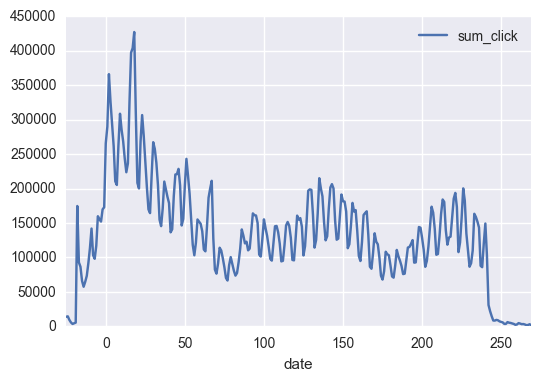

In [20]:
s.groupby(['date'])['sum_click'].sum().reset_index().plot(x='date', y='sum_click')

In [21]:
def add_clicks(data, day):
    # Get all data points on this day or prior, and sum them over the three columns we care about
    clicks = s[s['date'] <= day].groupby(['code_module', 'code_presentation', 'id_student'])['sum_click'].sum().reset_index()
    
    # Merge this data with the appropriate rows in the full data set
    full   = pd.merge(data, clicks, on=['code_module', 'code_presentation', 'id_student'], how='outer')
    
    # Replace any missing values with 0
    full['sum_click'].fillna(0, inplace=True)
    return full

In [22]:
from multiprocessing import Pool

assert(0), 'Kernel crash on windows'

# Multiprocessing can significantly speed up execution, and isn't too difficult to implement
# Define a function you want mapped to each sample in the data, and then apply it
def test_day(day):
    wclicks = add_clicks(data)
    cleaned = clean_data(wclicks)
    
    Y = cleaned['final_result'].replace({1:0, 2:1, 3:1}) # Fail, Withdraw, Pass, Distinction -> Incomplete, Complete
    X = cleaned.drop('final_result', axis=1)
    Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.2)

    model = XGBClassifier().fit(Xt, Yt)
    Y_hat = model.predict(Xv)
    return day, f1_score(Yv, Y_hat)

pool = Pool(4)
xy_performance = pool.map(test_day, sorted(s['date'].unique()))

AssertionError: Kernel crash on windows

In [23]:
from tqdm import tqdm 

# If multiprocessing isn't available, can still do the same work normally
xy_performance = []
for day in tqdm(sorted(s['date'].unique())):
    wclicks = add_clicks(data, day)
    cleaned = clean_data(wclicks)
    
    Y = cleaned['final_result'].replace({1:0, 2:1, 3:1}) # Fail, Withdraw, Pass, Distinction -> Incomplete, Complete
    X = cleaned.drop('final_result', axis=1)
    Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.2)

    model = XGBClassifier().fit(Xt, Yt)
    Y_hat = model.predict(Xv)
    xy_performance.append([day, f1_score(Yv, Y_hat)])

100%|██████████████████████████████████████████████████| 295/295 [06:40<00:00,  1.55s/it]


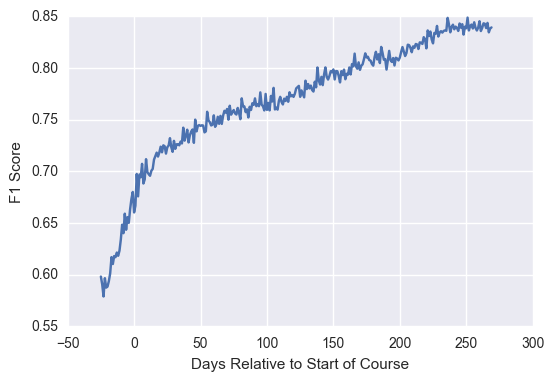

In [24]:
xy_performance = np.array(sorted(xy_performance, key=lambda k:k[0]))
plt.plot(*xy_performance.T)
plt.xlabel('Days Relative to Start of Course')
plt.ylabel('F1 Score')

So with just adding information about the number of clicks a student has made, we can improve the score significantly. Since we're looking at data going forward anyway, we can also add test scores.

In [25]:
student_scores = pd.read_csv('Data/StudentAssessment.csv')
display(student_scores)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78
1,1752,28400,22,0,70
2,1752,31604,17,0,72
...,...,...,...,...,...
173909,37443,546286,215,0,80
173910,37443,546724,230,0,100
173911,37443,558486,224,0,80


In [26]:
test_info = pd.read_csv('Data/assessments.csv')
display(test_info)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19,10.0
1,AAA,2013J,1753,TMA,54,20.0
2,AAA,2013J,1754,TMA,117,20.0
...,...,...,...,...,...,...
203,GGG,2014J,37436,TMA,124,0.0
204,GGG,2014J,37437,TMA,173,0.0
205,GGG,2014J,37444,Exam,229,100.0


In [27]:
combined_test = pd.merge(student_scores, test_info, on=['id_assessment'], how='outer')
combined_test = combined_test.replace({'?':np.nan}).dropna()
display(combined_test)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,11391.0,18.0,0.0,78,AAA,2013J,TMA,19,10.0
1,1752,28400.0,22.0,0.0,70,AAA,2013J,TMA,19,10.0
2,1752,31604.0,17.0,0.0,72,AAA,2013J,TMA,19,10.0
...,...,...,...,...,...,...,...,...,...,...
173909,37443,546286.0,215.0,0.0,80,GGG,2014J,CMA,229,0.0
173910,37443,546724.0,230.0,0.0,100,GGG,2014J,CMA,229,0.0
173911,37443,558486.0,224.0,0.0,80,GGG,2014J,CMA,229,0.0


In [28]:
c = combined_test.drop(['assessment_type', 'is_banked', 'id_assessment'], axis=1)

# Create a few new features, combining other columns together
c['relative_turnin'] = c['date'].astype(float) - c['date_submitted'].astype(float)
c['weighted_score']  = c['score'].astype(float) * c['weight'] / 100.
c['raw_score'] = c['score'].astype(float) # Modify type
display(c)

,id_student,date_submitted,score,code_module,code_presentation,date,weight,relative_turnin,weighted_score,raw_score
0,11391.0,18.0,78,AAA,2013J,19,10.0,1.0,7.8,78.0
1,28400.0,22.0,70,AAA,2013J,19,10.0,-3.0,7.0,70.0
2,31604.0,17.0,72,AAA,2013J,19,10.0,2.0,7.2,72.0
...,...,...,...,...,...,...,...,...,...,...
173909,546286.0,215.0,80,GGG,2014J,229,0.0,14.0,0.0,80.0
173910,546724.0,230.0,100,GGG,2014J,229,0.0,-1.0,0.0,100.0
173911,558486.0,224.0,80,GGG,2014J,229,0.0,5.0,0.0,80.0


In [29]:
def add_scores(data, day, key='date_submitted'):    
    # Same as before - get the relevant data and group by necessary columns
    assess = c[c['date_submitted'] <= day].groupby(['code_module', 'code_presentation', 'id_student'])

    # Sum over the relevant features
    total  = assess['raw_score', 'relative_turnin', 'weighted_score'].sum().reset_index()

    # Merge with the rest of the data
    full   = pd.merge(data, total, on=['code_module', 'code_presentation', 'id_student'], how='outer')

    # Replace missing values
    full['relative_turnin'].fillna(0, inplace=True)
    full['weighted_score'].fillna(0, inplace=True)
    full['raw_score'].fillna(0, inplace=True)
    return full

In [30]:
xy_performance = []
for day in tqdm(sorted(s['date'].unique())):
    wclicks = add_clicks(data, day)
    wscores = add_scores(wclicks, day)
    cleaned = clean_data(wscores)
    
    Y = cleaned['final_result'].replace({1:0, 2:1, 3:1}) # Fail, Withdraw, Pass, Distinction -> Incomplete, Complete
    X = cleaned.drop('final_result', axis=1)
    Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.2)

    model = XGBClassifier().fit(Xt, Yt)
    Y_hat = model.predict(Xv)
    xy_performance.append([day, f1_score(Yv, Y_hat)])

100%|██████████████████████████████████████████████████| 295/295 [06:48<00:00,  1.66s/it]


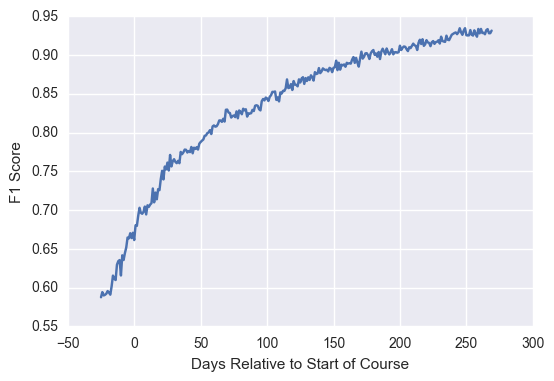

In [31]:
xy_performance = np.array(sorted(xy_performance, key=lambda k:k[0]))
plt.plot(*xy_performance.T)
plt.xlabel('Days Relative to Start of Course')
plt.ylabel('F1 Score')

So, not bad: we can predict with ~80% accuracy whether a student will complete the course after only about a month and a half - 20% of the way through. <br><br>Even at the first day of the course, we're at nearly 70%. Let's take a look at how each of the original objectives fare over time...

In [32]:
from tqdm import tqdm 
from xgboost.sklearn import XGBClassifier
xy_performance = []
for day in tqdm(sorted(s['date'].unique())):
    wclicks = add_clicks(data, day)
    wscores = add_scores(wclicks, day)
    cleaned = clean_data(wscores)
    
    Y = cleaned['final_result']
    X = cleaned.drop('final_result', axis=1)
    Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.2)

    model = XGBClassifier().fit(Xt, Yt)
    Y_hat = model.predict(Xv)
    xy_performance.append([day,] + list(f1_score(Yv, Y_hat, average=None)))

100%|██████████████████████████████████████████████████| 295/295 [21:04<00:00,  4.79s/it]


,Days,Fail,Withdraw,Pass,Distinction
0,-25.0,0.179473,0.483078,0.556137,0.009554
1,-24.0,0.172376,0.482775,0.547550,0.009868
2,-23.0,0.184946,0.490034,0.562993,0.013865
...,...,...,...,...,...
292,267.0,0.422509,0.783210,0.835740,0.567623
293,268.0,0.427434,0.774001,0.820835,0.512097
294,269.0,0.427516,0.786645,0.828566,0.534274


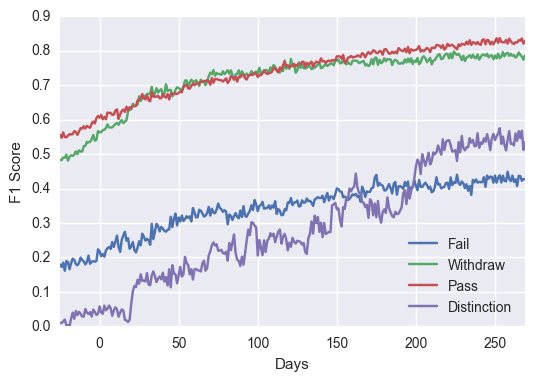

In [33]:
XY = np.array(sorted(xy_performance, key=lambda k:k[0]))
XY = pd.DataFrame(XY, columns=['Days', 'Fail', 'Withdraw', 'Pass', 'Distinction'])
display(XY)

import seaborn as sns
%matplotlib inline
XY.plot(x='Days').set_ylabel('F1 Score')


Machine learning is an iterative process over two steps:
 - Improve the data
 - Improve the model
 
When possible, improving the objective can also help.

# Advanced Topics

- **Translation**. Not necessarily just language to language, but in general data to data where the two sets have a (nearly) one-to-one mapping. Autoencoders are popular for this right now, e.g. Seq2Seq
<br><br>
- **Deep NLP**. Any time you want to use text as the feature in a neural network, word vector embeddings are the go to representation e.g. GloVe. Long short-term memory units are the building blocks for most models, and recurrent networks in general tend to perform fairly well.
<br><br>
- **Temporal data**. Recurrent networks are the standard model when trying to extract temporal relationships within a data set. Recurrent networks can also be used for a number of other cool applications: https://distill.pub/2016/augmented-rnns/ . Aside from those, reservoir computing networks (Echo State Networks & Liquid State Machines) are some lesser known but powerful models (and also my favorite topics).
<br><br>
- **Small data set**. The general notion is that you need a _lot_ of data to perform deep learning. While it helps, it's not necessarily a requirement - Generative Adversarial Networks can help to create a simulated data set which is 'good enough' for getting a training process started. Utilizing these correctly can take some work however. 
<br><br>
- **Image to image**. Also GAN domain, though depending on the specific application convolutional networks are useful as well (and are actually the building blocks for GANs. 
<br><br>
- **Markov Processes**. Anything that can be imagined as taking actions in a state to reach a goal (or optimize the state) are typically the domain of reinforcement learning. The standard research environment (or most visible at least) is in game playing: there's an obvious state transition function, action mapping, and reward sequence to train a model. Plus, there's no shortage of environments.
<br><br>
- **Different data domains**. If you have say, a _large_ set of simulated data or data which is particular to a specific domain, but you want to create a model which can learn a _related_ domain. There is a lot of research on transfer learning happening right now, where models trained on one domain can transfer knowledge of what they learned to be used in the separate (but somehow related) domain. 
<br><br>
- Tons of other models for nearly any problem you can think of. Any which I haven't mentioned?